In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import SimpleITK as sitk
plt.rcParams["figure.figsize"] = (20,5)

In [3]:
# get data dir
TRAIN_DIR = "./data/train/"
EXAMPLE = TRAIN_DIR + "00009/FLAIR"

In [4]:
def read_dicom_series(path):
    """
    reads a dicom series (a list of files) represented by the input path
    
    args:
    path -- the path to the dicom folder
    """
    reader = sitk.ImageSeriesReader()
    fpaths = reader.GetGDCMSeriesFileNames(path)
    reader.SetFileNames(fpaths)
    return reader.Execute()

def show_image(im):
    fig, axs = plt.subplots(1,3)
    arr = sitk.GetArrayFromImage(im)

    axs[0].imshow(
        arr[arr.shape[0]//2,:,:],
        aspect='auto')
    axs[0].set_title("normal 0")
    axs[1].imshow(
        arr[:,arr.shape[1]//2,:],
        aspect='auto')
    axs[1].set_title("normal 1")
    axs[2].imshow(
        arr[:,:,arr.shape[2]//2],
        aspect='auto')
    axs[2].set_title("normal 2")

def resample_image(image, resample_spacing=None):
    """
    resamples a SimpleITK image
    """
    if resample_spacing == None:
        return image 
    else:
        # get pre voxel size and image size
        pre_vs = image.GetSpacing()
        pre_is = image.GetSize()
        
        # calculate post voxel size and
        post_is = [
            int(np.round(pre_is[0] * (pre_vs[0] / 2))),
            int(np.round(pre_is[1] * (pre_vs[1] / 2))),
            int(np.round(pre_is[2] * (pre_vs[2] / 2))) 
        ]
        
        return sitk.Resample(
            image1 = image,
            size = post_is,
            transform = sitk.Transform(),
            interpolator = sitk.sitkBSpline,
            outputOrigin = image.GetOrigin(),
            outputSpacing = resample_spacing,
            outputDirection = image.GetDirection(),
            defaultPixelValue = 0.0,
            outputPixelType = image.GetPixelID()
        )

def permute_norm(x, plane):
    norm_hash =  x[1] + 2*x[2]
    if plane == "Axial":
        return int(norm_hash)
    elif plane == "Sagittal":
        raise NotImplementedError
    elif plane == "Coronal":
        raise NotImplementedError
    else:
        raise ValueError("Specified Plane does not exist")

def rotate_image(image, plane="Axial"):
    pre_norms = np.abs(np.round(image.GetDirection()))
    pre_norms = pre_norms.astype(int)
    
    # calculate the permutation for each normal vector and wrap in tuple
    post_norms = [
        permute_norm(pre_norms[0:3], plane),
        permute_norm(pre_norms[3:6], plane),
        permute_norm(pre_norms[6:9], plane)
    ]    
    
    return sitk.PermuteAxes(image, post_norms)
    
    


In [6]:
image = read_dicom_series(EXAMPLE)
resampledImage = resample_image(image, [2,2,2])

ImageSeriesReader (0x563fe607e6b0): Non uniform sampling or missing slices detected,  maximum nonuniformity:9.14411e-05



array([0, 0, 1, 1, 0, 0, 0, 1, 0])

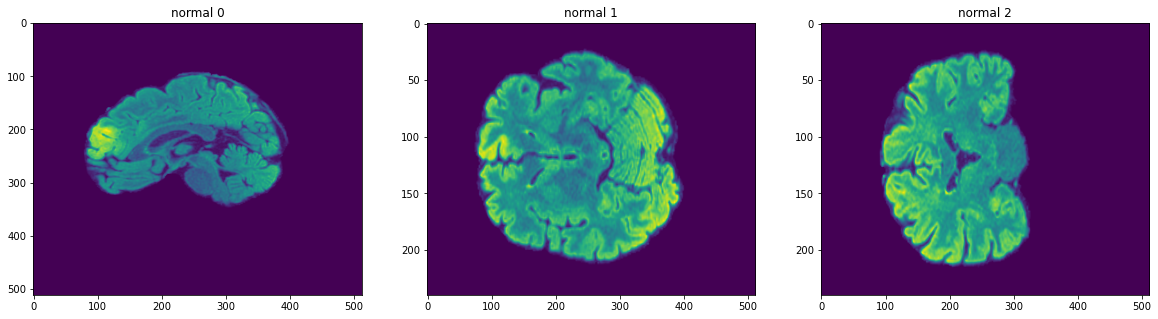

In [7]:
show_image(image)
np.abs(np.round(image.GetDirection())).astype(int)

array([-1., -0.,  0., -0.,  1., -0., -0., -0., -1.])

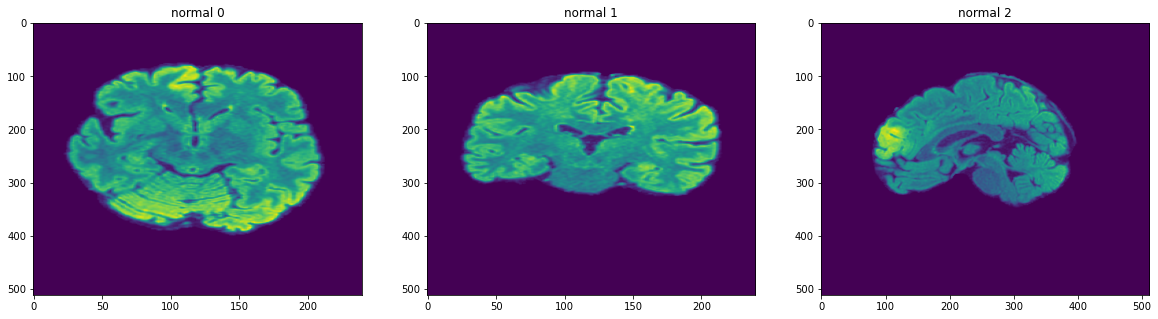

In [8]:
# rotate image
rot_image = rotate_image(image)
show_image(rot_image)
np.round(rot_image.GetDirection())

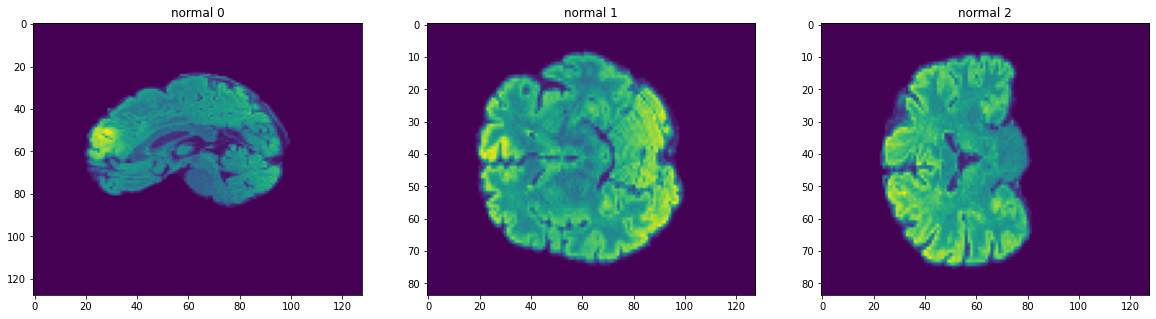

In [9]:
show_image(resampledImage)

In [10]:
image.GetSpacing()

(0.5, 0.5, 0.6999997850497486)